In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from createImage import createImage
from createImage import analyzeImage

Create set of images with single Gaussian object moving.

In [4]:
t0Pos = [10., 10.]
velocity = [6., 12.]
imageTimes = np.arange(1,6,2)
imageSize = [90., 90.]
gaussianSigma = [5., 5.]
backgroundLevel = [100.]
gaussMax = [500.]
fileName = 'test'
createImage().createSingleSet(fileName, t0Pos, velocity, imageTimes, imageSize,
                              backgroundLevel, gaussMax, gaussianSigma)

Now open fits file with images.

In [5]:
hdulist = fits.open('test.fits')

In [6]:
hdulist.info()

Filename: test.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       7   (90, 90, 3)   float64   


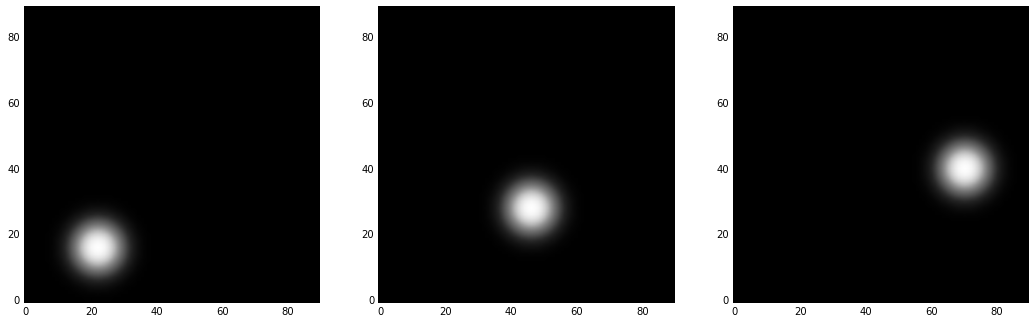

In [7]:
fig = plt.figure(figsize=(18, 6))
for imNum in range(0, 3):
    fig.add_subplot(1, 3, imNum+1)
    plt.imshow(hdulist[0].data[imNum], cmap=mpl.cm.Greys_r, origin='lower')

With images loaded we can covolve each image with a Gaussian and plot the results.

/Users/Bryce/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


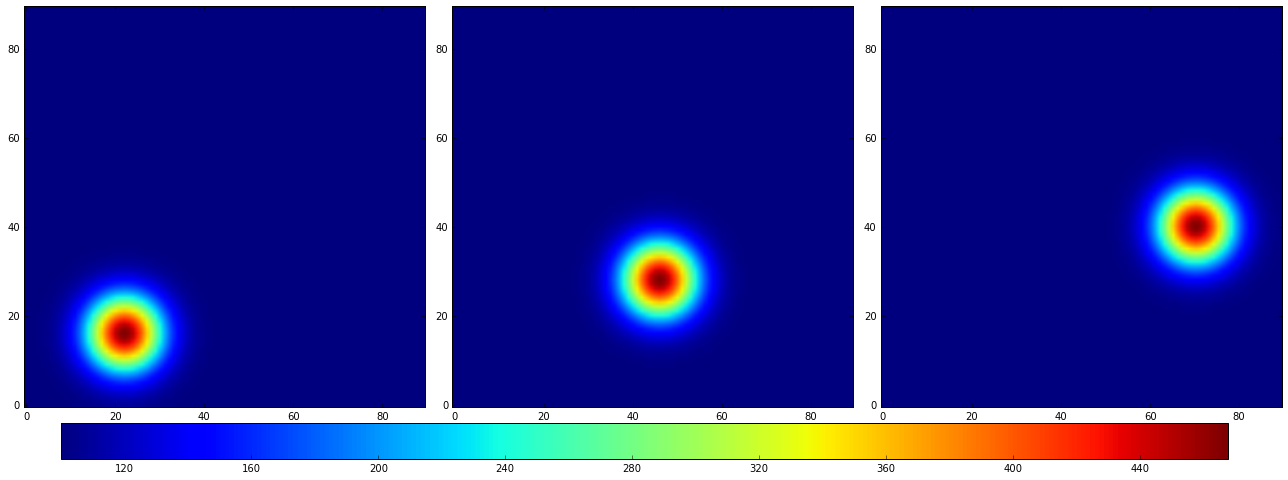

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 10)
kernel_sigma = [3., 3.]
for ax, imNum in zip(axes.flat, np.arange(3)):
    im = ax.imshow(analyzeImage().convolveGaussian(hdulist[0].data[imNum], kernel_sigma), 
                   origin='lower')
cbar_ax = fig.add_axes([0.05, 0.15, 0.9, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.tight_layout()

We can also measure the flux at each point along a trajectory.

In [13]:
fluxResults = analyzeImage().measureFlux(hdulist[0].data, t0Pos, velocity, imageTimes, 5.)

Trajectory Coordinates: 
[[ 16.  22.]
 [ 28.  46.]
 [ 40.  70.]]
Flux values at coordinates:  [[600.0], [600.0], [600.0]]
